In [1]:
from nanodrivers.visa_drivers.anapico import ANAPICO
from nanodrivers.visa_drivers.dc import DC
from nanodrivers.visa_drivers.vna import VNA

#math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit

#plotting
import matplotlib.pyplot as plt
import matplotlib

#matlab import
import scipy.io
from scipy.io import savemat
from scipy.optimize import minimize

#file_store
import os

#time
import time
from datetime import datetime, timedelta


from ctypes import *
%matplotlib inline

C:\Users\Demag\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
anapico = ANAPICO()
anapico.idn()

Connection exist: AnaPico AG,APMS20G,3C6-0B4F40003-0985,1.0.7



In [3]:
dc = DC()
dc.idn()

Connection exist: HEWLETT-PACKARD,33120A,0,7.0-5.0-1.0



In [24]:
vna = VNA()
vna.idn()

Connection exist: Rohde-Schwarz,ZNB20-2Port,1311601062102129,3.45



# Check if TWPA works

In [47]:
folder = r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\VTT_12"
exp_name = '1GHz_cav'
path = folder+'\\'+exp_name
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  print("Folder %s already exists" % path)

Folder C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\VTT_12\1GHz_cav already exists


In [59]:
# %matplotlib qt
font = {'size'   : 15}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(2, 1, figsize = (15, 7), sharex = True)
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Freq, GHz')
ax[0].set_ylabel('Pha, db')
ax[1].set_xlabel('Freq, GHz')
ax[1].set_ylabel('Mag, db')


vna.set_power(-10)
mag, pha = vna.get_data()
freq = vna.get_freq()
ax[0].plot(freq/1e9, pha, label = 'no gain')
ax[1].plot(freq/1e9, mag, label = 'no gain')


vna.set_power(0)
mag, pha = vna.get_data()
ax[0].plot(freq/1e9, pha, label = 'no gain')
ax[1].plot(freq/1e9, mag, label = 'no gain')

In [60]:
file = r'full.mat'
file_name = path +'\\' + file
state = dict()
state['mag'] = mag
state['pha'] = pha
state['power'] = 0
state['freq'] = freq
savemat(file_name, state)

In [31]:
vna.write('SENS1:FREQ: STAR {}'.format(str(4e9)))

In [32]:
vna.get_start_freq()

3500000000.0

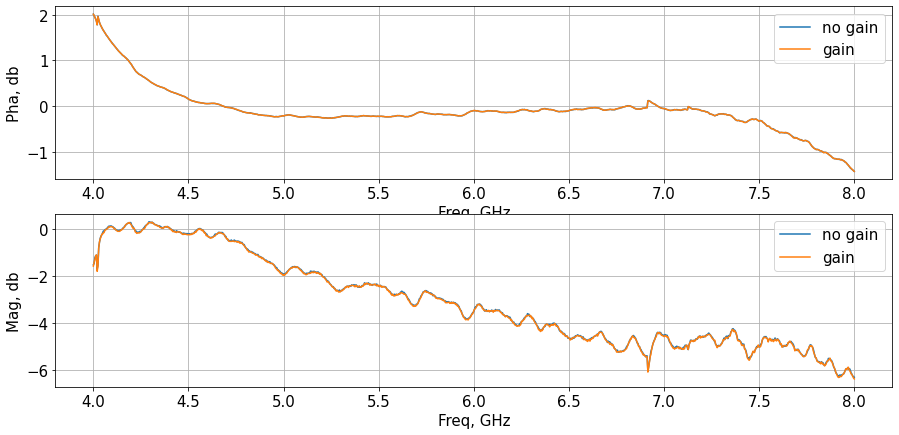

In [17]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

# NOTE!!!
max_volt = 1.5 

fig, ax = plt.subplots(2, 1, figsize = (15, 7))
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Freq, GHz')
ax[0].set_ylabel('Pha, db')
ax[1].set_xlabel('Freq, GHz')
ax[1].set_ylabel('Mag, db')

# Initial
anapico.set_off(1)
dc.set_volt(0)

vna.set_band(1000)
vna.set_nop(1000)
vna.set_power(-20)
# vna.set_elength(13.4)
vna.set_freq_start_stop(4e9, 8.5e9, vna.get_nop())
mag, pha = vna.get_data()
freq = vna.get_freq()
ax[0].plot(freq/1e9, pha, label = 'no gain')
ax[1].plot(freq/1e9, mag, label = 'no gain')

# anapico.set_on(1)
dc.set_volt(max_volt)
time.sleep(30)
mag, pha = vna.get_data()
ax[0].plot(freq/1e9, pha, label = 'gain')
ax[1].plot(freq/1e9, mag, label = 'gain')

ax[0].legend()
ax[1].legend()
dc.set_volt(0)

In [ ]:
dc.set_volt(0)
pha_c = np.array([])
time_c = np.array([])

vna.set_cw_freq(5e9)
vna.set_nop(1000)
vna.set_power(-10)
vna.set_band(1000)

start_time = datetime.now()
vna.set_on()
time_run = vna.get_sweep_time()


vna.write("INIT1:IMM")
time.sleep(0.2 + time_run)
data_str = vna.query("CALC1:DATA? SDAT")
data = np.array(data_str.rstrip().split(",")).astype("float64")
s = data[0::2] + 1j * data[1::2]

ini_pha = angle(s)

dc_arr = np.linspace(0, 0.1, 40)

for i in range(len(dc_arr)):
    
    dc.set_volt(dc_arr[i])

    vna.write("INIT1:IMM")
    time.sleep(0.2 + time_run)
    data_str = vna.query("CALC1:DATA? SDAT")
    data = np.array(data_str.rstrip().split(",")).astype("float64")
    s = data[0::2] + 1j * data[1::2]

    c_time = datetime.now()
    time_c = np.append(time_c, (c_time-start_time).seconds)
    
    pha_c = np.append(pha_c, angle(s))
    
    
    dc.set_volt(0)

    
    vna.write("INIT1:IMM")
    time.sleep(0.2 + time_run)
    data_str = vna.query("CALC1:DATA? SDAT")
    data = np.array(data_str.rstrip().split(",")).astype("float64")
    s = data[0::2] + 1j * data[1::2]

    c_time = datetime.now()
    time_c = np.append(time_c, (c_time-start_time).seconds)
    
    pha_c = np.append(pha_c, angle(s))